# 8-BenchmarkSummary
This notebook evaluates the scaling of Dask, Spark, and DaskCuda dataframe libraries with respect to the number of cores and the file format of the data file ([csv](https://en.wikipedia.org/wiki/Comma-separated_values). vs. [parquet](https://parquet.apache.org/)). 

To run this notebook, execute the benchmark.sb script. This notebook reads the benchmark resuls from the [results directory](results). 

Note: this is not a representative comparison of these dataframe libraries.

See Robert Sinkovits' introduction to [Parallel Computing Concepts](https://github.com/sdsc/sdsc-summer-institute-2022/tree/main/2.1_parallel_computing_concepts).

Author: Peter W. Rose (pwrose@ucsd.edu)

In [47]:
import os
import numpy as np
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import ipywidgets as widgets

If LOCAL_SCRATCH_DIR environment variable is not set, this notebook accesses the ../data directory for temporary files.

In [2]:
DATA_DIR = os.getenv("LOCAL_SCRATCH_DIR", default="../data")
filename = os.path.join(DATA_DIR, "gene_info.tsv")
file_size = f"{os.path.getsize(filename)/1E9:.1f}"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

## Read benchmark results

In [3]:
df = dd.read_csv(os.path.join(RESULTS_DIR, "*.csv"))
df = df.compute()

In [51]:
formats = df["format"].unique()
sizes = df["size"].unique()
sizes.sort()
dataframes = df["dataframe"].unique()
cores = df["cores"].unique()
cores.sort()
max_cores = df["cores"].max()

print(f"Formats    : {formats}")
print(f"Sizes      : {sizes}")
print(f"Dataframes : {dataframes}")
print(f"Max. cores : {max_cores}")

Formats    : ['csv' 'parquet']
Sizes      : [ 5.5 10.9 21.9 43.9 87.7]
Dataframes : ['Dask' 'Spark' 'DaskCuda']
Max. cores : 16


## Plot Scaling for various dataset sizes and  dataframe libraries
The linear dashed lines show runtimes for perfect scaling in the log2 - log plot.

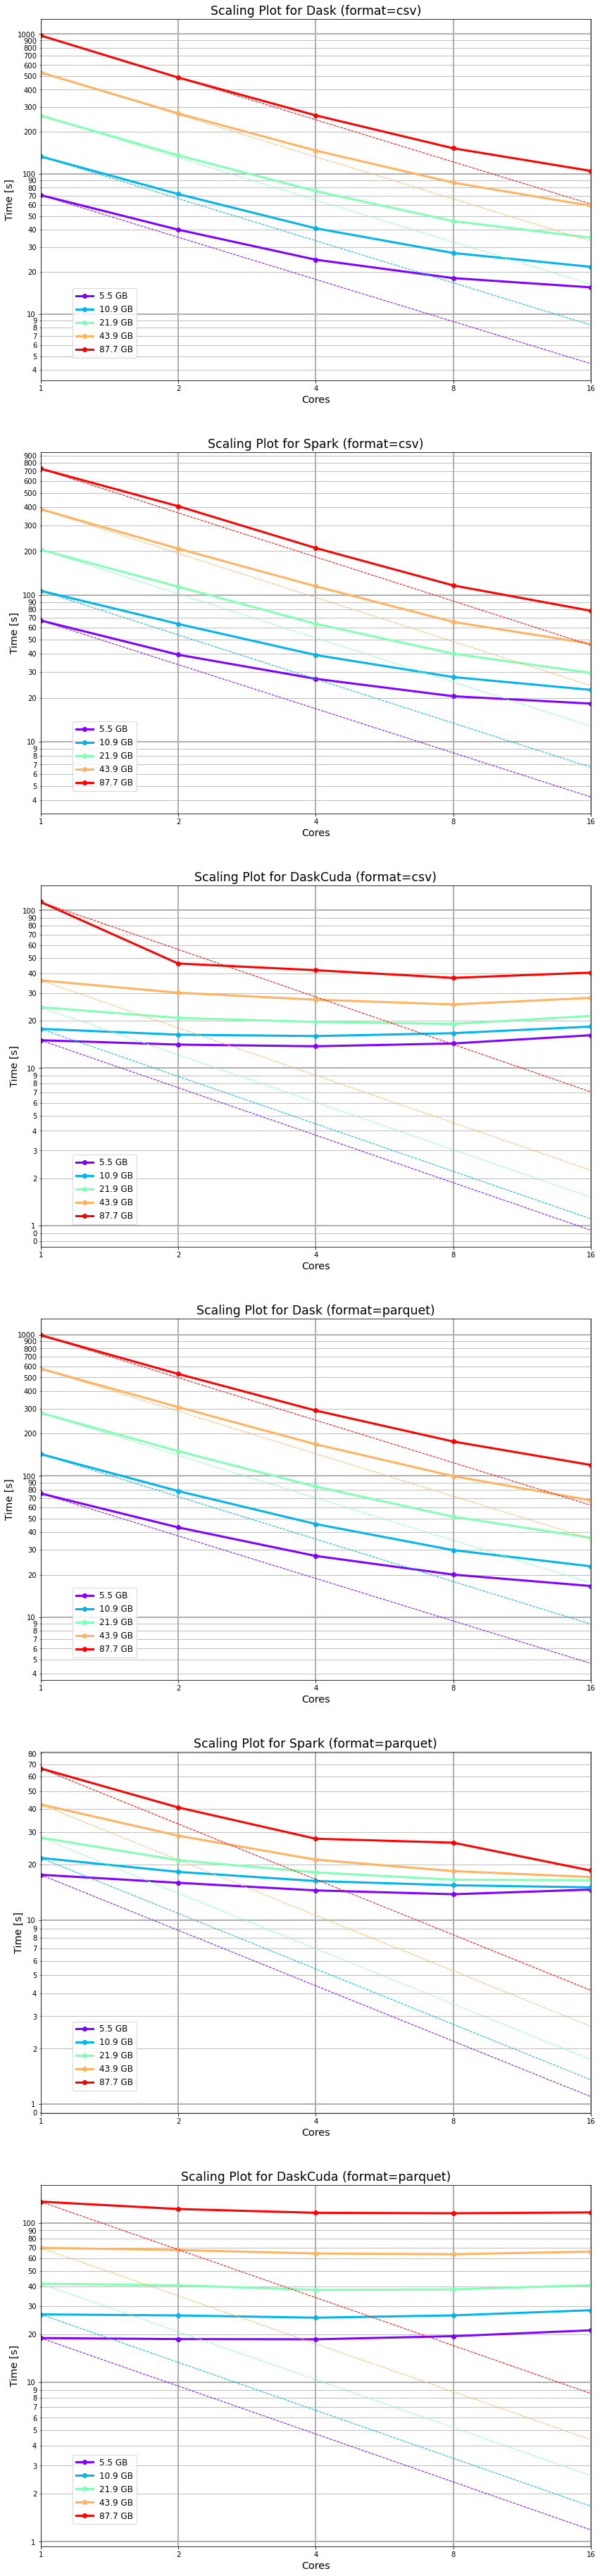

In [5]:
n_rows = len(formats) * len(dataframes)

fig, axs = plt.subplots(nrows=n_rows, ncols=1, figsize=(14, 11*n_rows))
colors = cm.rainbow(np.linspace(0, 1, len(sizes)))

for i, frmt in enumerate(formats):
    for j, dtfrm in enumerate(dataframes):
        for s, c in zip(sizes, colors):
            dp = df[(df["format"] == frmt) & (df["dataframe"] == dtfrm) & (df["size"] == s)].copy()
            ix = i * len(dataframes) + j
            axs[ix].set_xscale('log', base=2)
            axs[ix].set_yscale('log')
            for axis in [axs[ix].xaxis, axs[ix].yaxis]:
                formatter = matplotlib.ticker.FormatStrFormatter("%d")
                axis.set_major_formatter(formatter)
                axis.set_minor_formatter(formatter)
            axs[ix].grid(visible=True, which='major', linewidth=2)
            axs[ix].grid(visible=True, which='minor')

            axs[ix].set_title(f"Scaling Plot for {dtfrm} (format={frmt})", fontsize="xx-large")
            axs[ix].set_xlabel("Cores", fontsize="x-large")
            axs[ix].set_ylabel("Time [s]", fontsize="x-large")
            axs[ix].set_xlim([1, max_cores])
            axs[ix].plot(dp["cores"].values, dp["time"].values, color=c, marker="o", linewidth=3, label=f"{s} GB")
            axs[ix].plot(dp["cores"].values, dp["linear"].values, color=c, linestyle="dashed", linewidth=1)
            axs[ix].legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), fontsize='large', frameon=True)

## Parallel Efficiency
* Time: observed runtime
* Parallel efficiency: measure of resource utilization for parallel processing

For perfect scaling the parallel efficiency is 1.0.

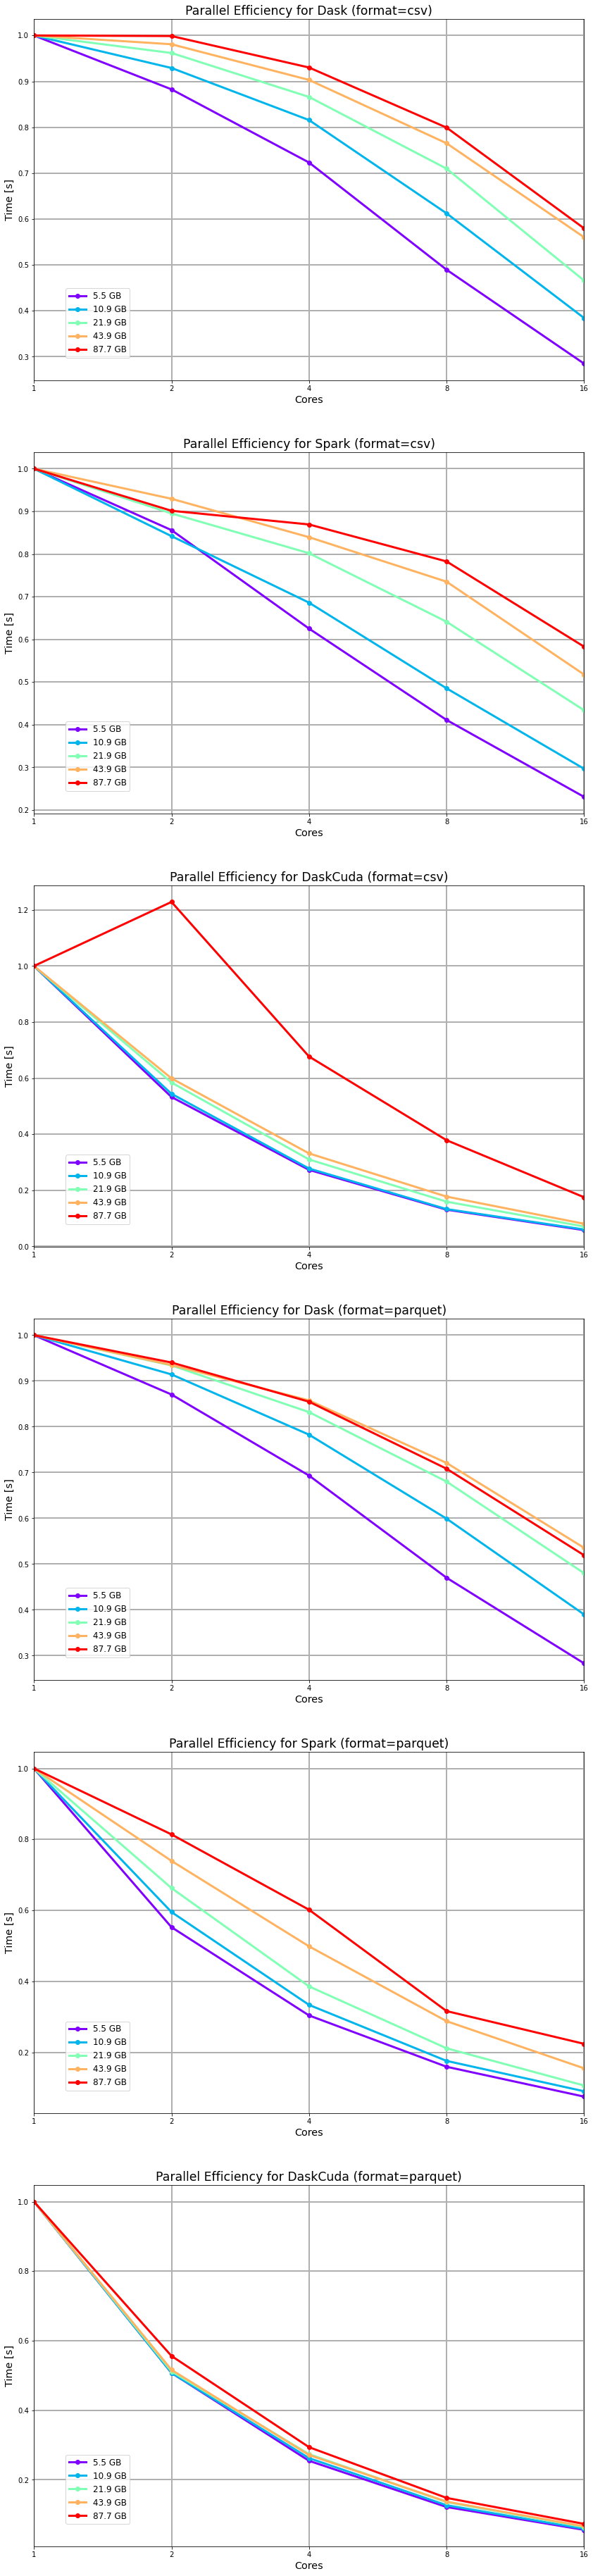

In [6]:
n_rows = len(formats) * len(dataframes)

fig, axs = plt.subplots(nrows=n_rows, ncols=1, figsize=(14, 11*n_rows))
colors = cm.rainbow(np.linspace(0, 1, len(sizes)))

for i, frmt in enumerate(formats):
    for j, dtfrm in enumerate(dataframes):
        for s, c in zip(sizes, colors):
            dp = df[(df["format"] == frmt) & (df["dataframe"] == dtfrm) & (df["size"] == s)].copy()
            ix = i * len(dataframes) + j
            axs[ix].set_xscale('log', base=2)
            formatter = matplotlib.ticker.FormatStrFormatter("%d")
            axs[ix].xaxis.set_major_formatter(formatter)
            axs[ix].xaxis.set_minor_formatter(formatter)
            axs[ix].grid(visible=True, which='major', linewidth=2)
            axs[ix].grid(visible=True, which='minor')

            axs[ix].set_title(f"Parallel Efficiency for {dtfrm} (format={frmt})", fontsize="xx-large")
            axs[ix].set_xlabel("Cores", fontsize="x-large")
            axs[ix].set_ylabel("Time [s]", fontsize="x-large")
            axs[ix].set_xlim([1, max_cores])
            axs[ix].plot(dp["cores"].values, dp["efficiency"].values, color=c, marker="o", linewidth=3, label=f"{s} GB")
            axs[ix].legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), fontsize='large', frameon=True)

## Comparison of Dataframe Libraries and File Formats

In [140]:
style = {'description_width': "initial"}
c_widget = widgets.RadioButtons(options=cores, description="Select number of cores:", style=style)
s_widget = widgets.RadioButtons(options=sizes, description="Select dataset size (GB):", style=style)

In [163]:
display(c_widget, s_widget)

RadioButtons(description='Select number of cores:', index=4, options=(1, 2, 4, 8, 16), style=DescriptionStyle(…

RadioButtons(description='Select dataset size (GB):', index=4, options=(5.5, 10.9, 21.9, 43.9, 87.7), style=De…

In [164]:
n_cores = c_widget.value
size = s_widget.value
print(f"cores {n_cores}, size {size}")

cores 16, size 87.7


In [165]:
dc = df[(df["cores"] == n_cores) & (df["size"] == size)].copy()

In [166]:
dc

,cores,time,efficiency,linear,size,format,dataframe
4,16,105.349739,0.579701,61.071390,87.7,csv,Dask
4,16,119.824530,0.519194,62.212236,87.7,parquet,Dask
4,16,78.410610,0.582823,45.699530,87.7,csv,Spark
4,16,18.533379,0.223964,4.150807,87.7,parquet,Spark
4,16,40.341539,0.175353,7.073991,87.7,csv,DaskCuda
4,16,116.789789,0.073026,8.528709,87.7,parquet,DaskCuda


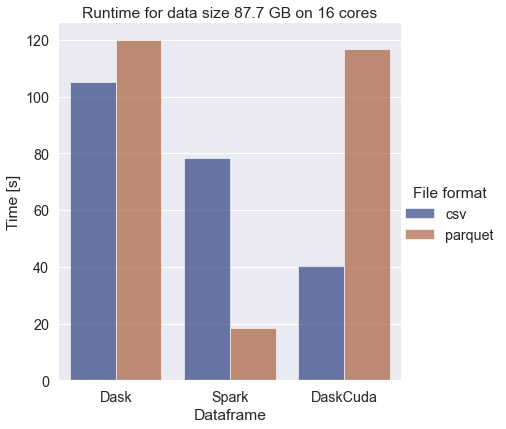

In [167]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.3)
g = sns.catplot(data=dc, kind="bar", x="dataframe", y="time", hue="format", palette="dark", alpha=.6, height=6)
g.set(title=f"Runtime for data size {size} GB on {n_cores} cores")
g.despine(left=True)
g.set_axis_labels("Dataframe", "Time [s]")
g.legend.set_title("File format")